In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from urllib.parse import urlparse
import shap
import warnings
warnings.filterwarnings("ignore")

c:\Users\Mohammad\Downloads\MLFlowStarter\Nasrenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

data=pd.read_csv('Rainfall.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [4]:
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [5]:
data.duplicated().sum()

0

In [6]:
data.columns=data.columns.str.strip()

In [7]:
data.replace({"rainfall":{"yes":1,"no":0}},inplace=True)

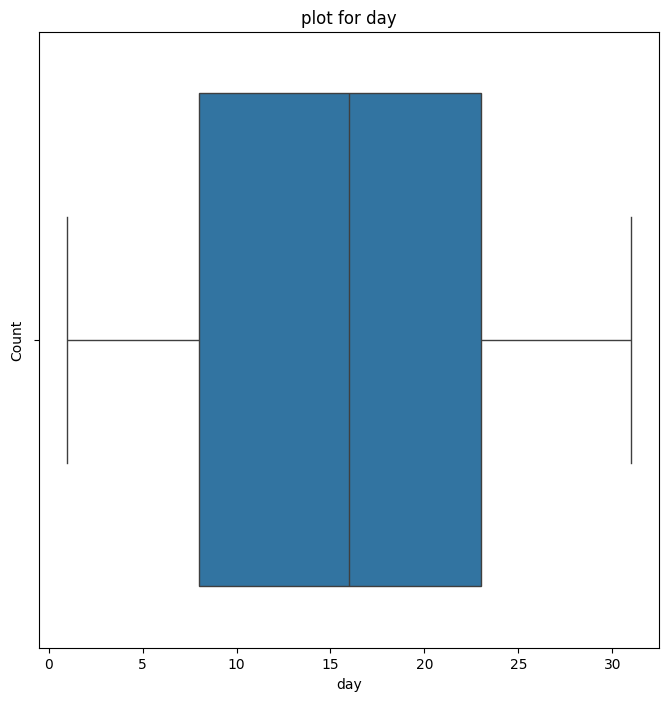

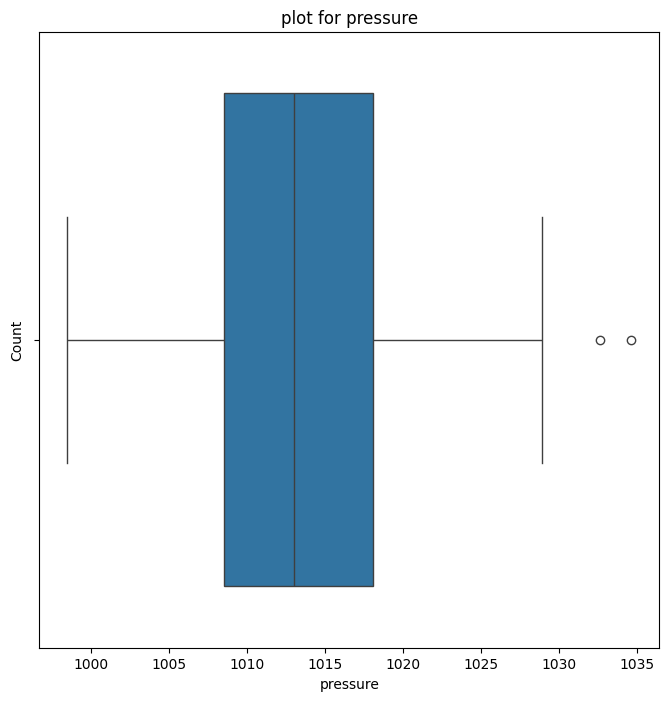

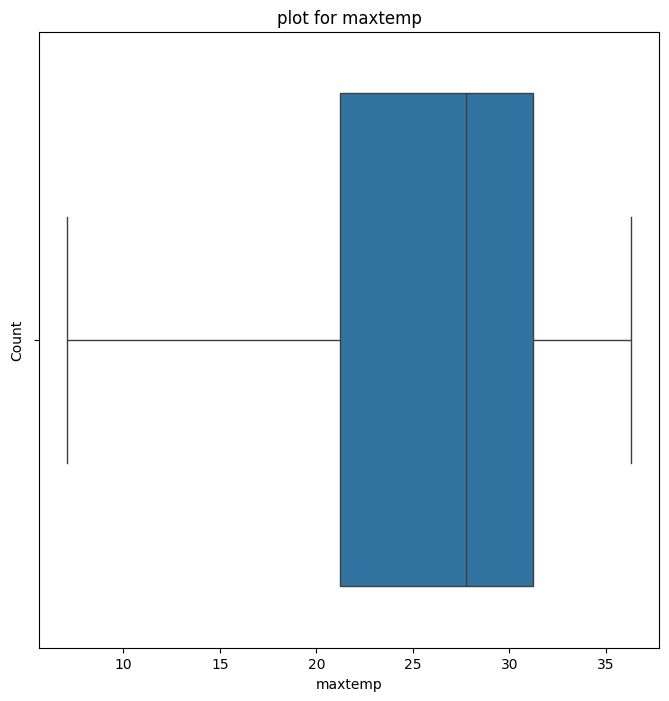

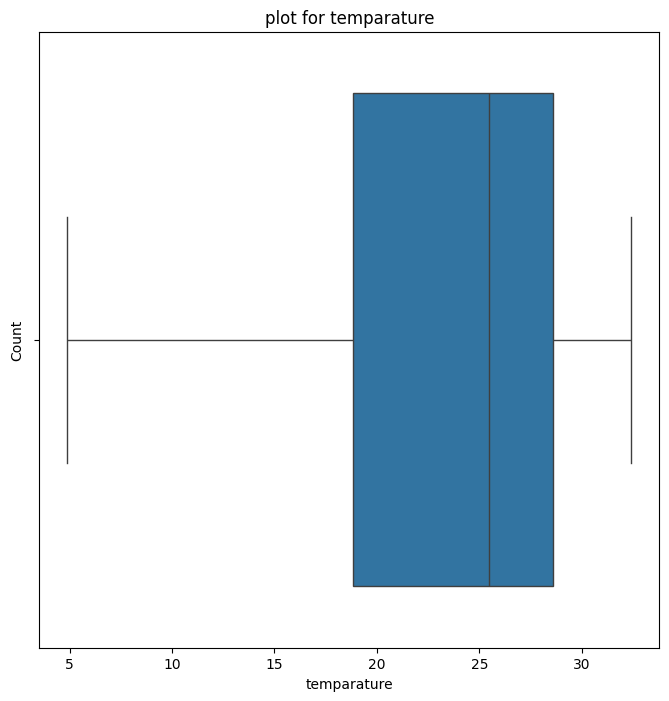

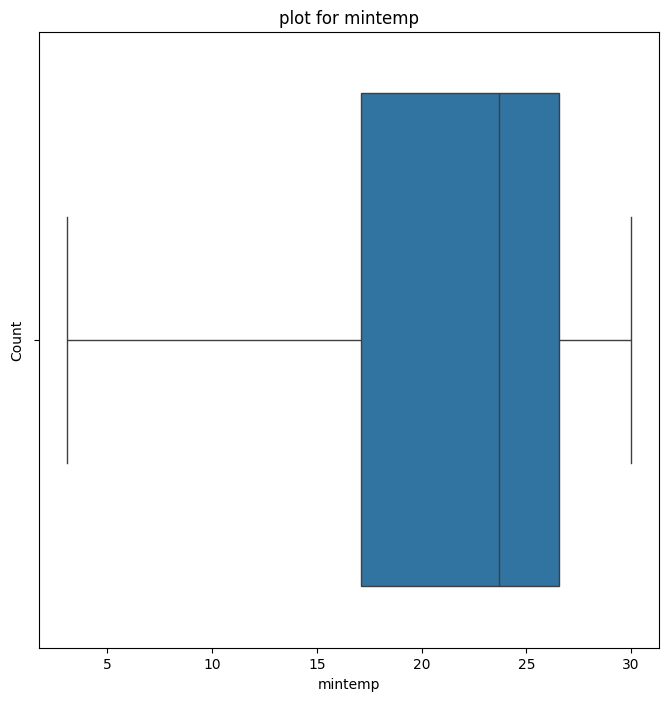

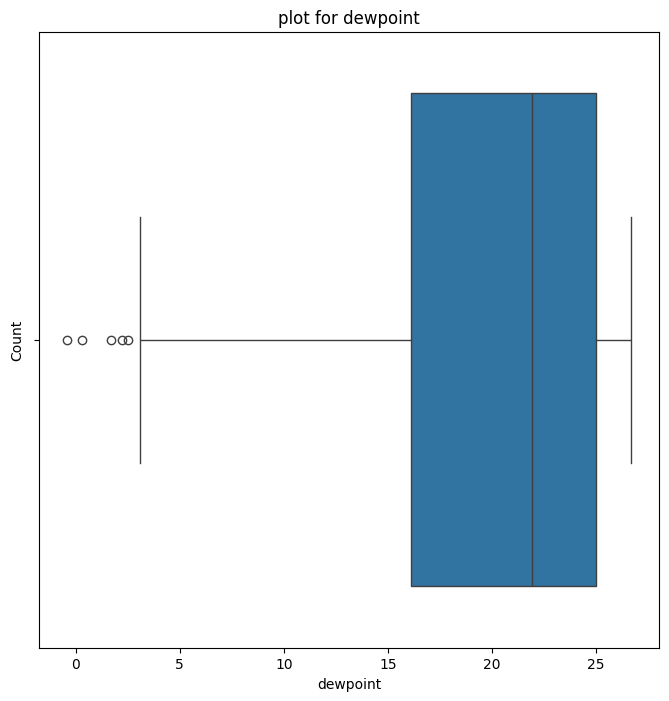

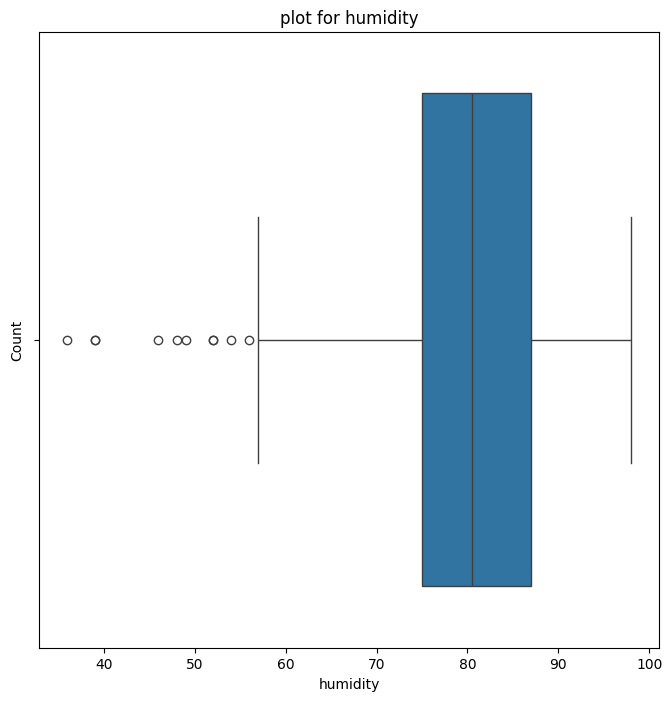

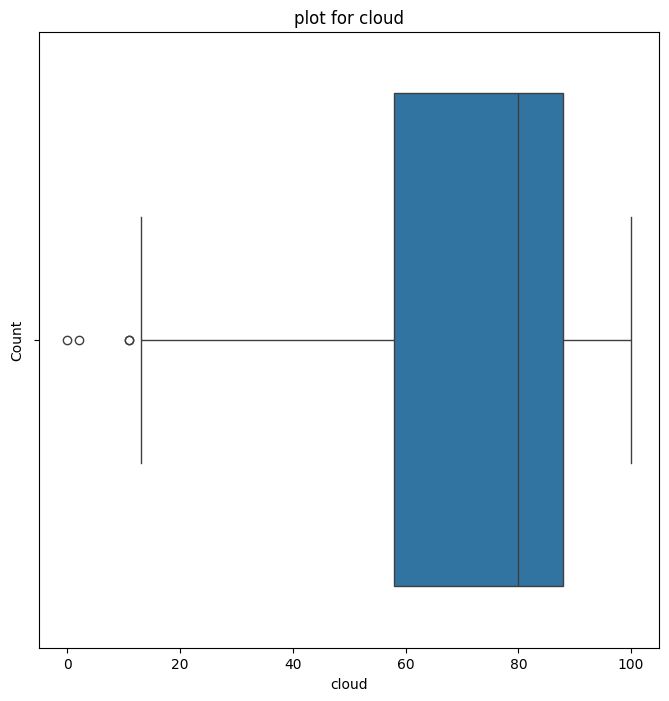

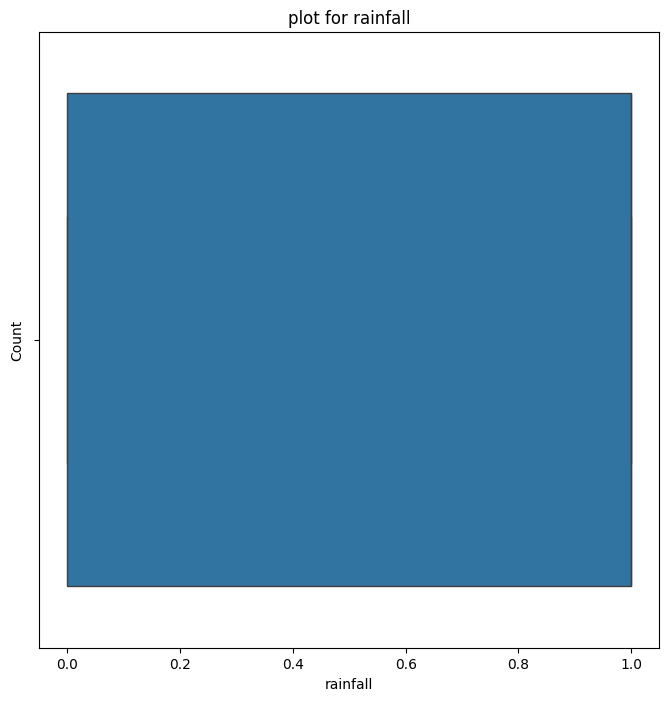

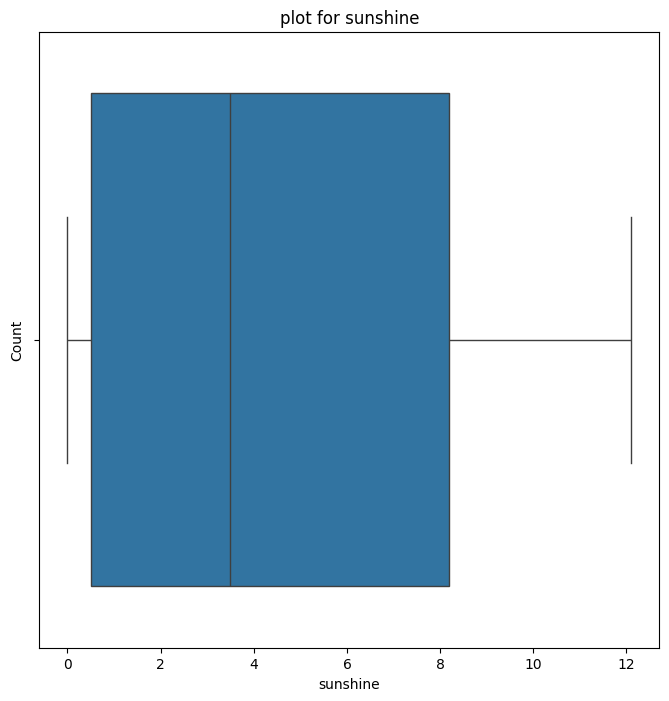

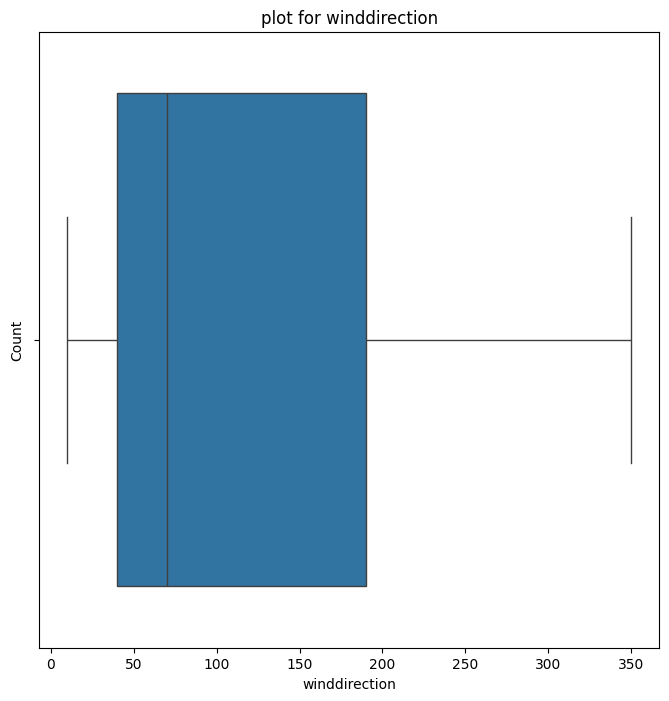

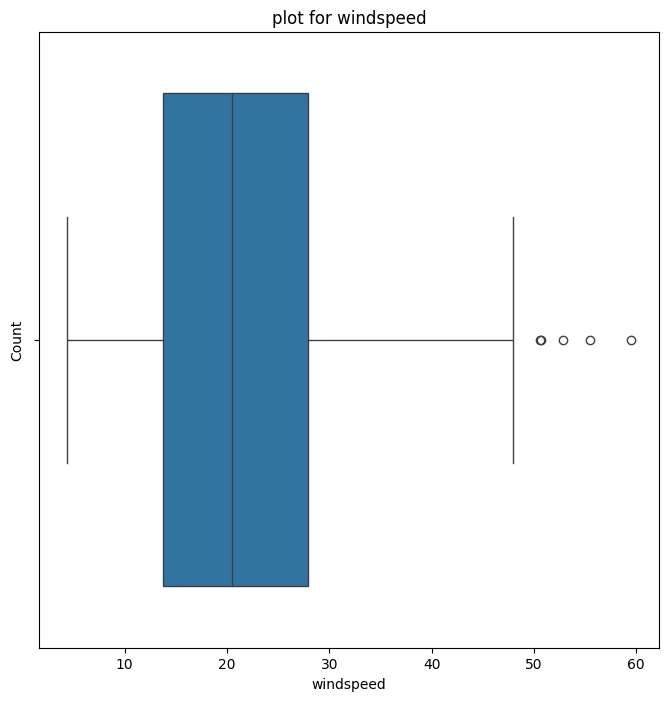

In [8]:
for column in data:  
    plt.figure(figsize=(8, 8))  
    plt.title(f"plot for {column}")  
    sns.boxplot(x=data[column])  
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

In [9]:
def remove_outliers(data):
    data_without_outliers = data.copy()  
    for column in data.columns:
        Q1 = data[column].quantile(0.25)  
        Q3 = data[column].quantile(0.75)  
        IQR = Q3 - Q1  
        lower_bound = Q1 - 1.5 * IQR  
        upper_bound = Q3 + 1.5 * IQR  
        data_without_outliers = data_without_outliers[(data_without_outliers[column] >= lower_bound) & 
                                                      (data_without_outliers[column] <= upper_bound)]
    
    return data_without_outliers


In [10]:
data=remove_outliers(data)

In [11]:
X=data.drop(columns='rainfall')
Y=data["rainfall"]

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [12]:
def show_nulls(x_train,x_test):

    print(x_train.isna().sum())
    print(20*"-")
    print(x_test.isna().sum())
    
    
show_nulls(x_train,x_test)    

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64
--------------------
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64


In [13]:
show_nulls(y_train,y_test) 

0
--------------------
0


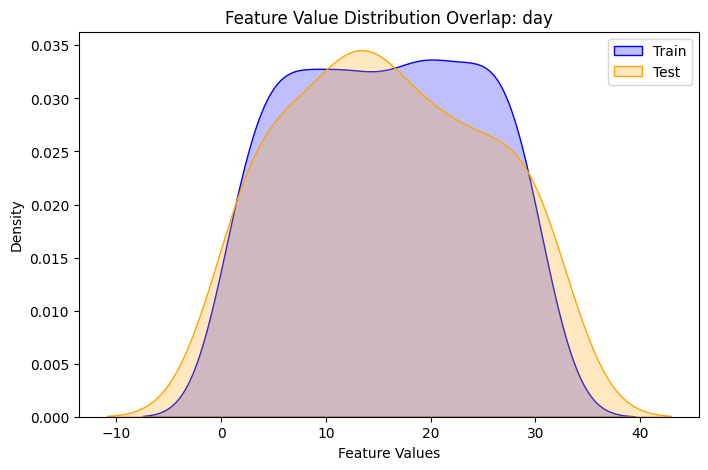

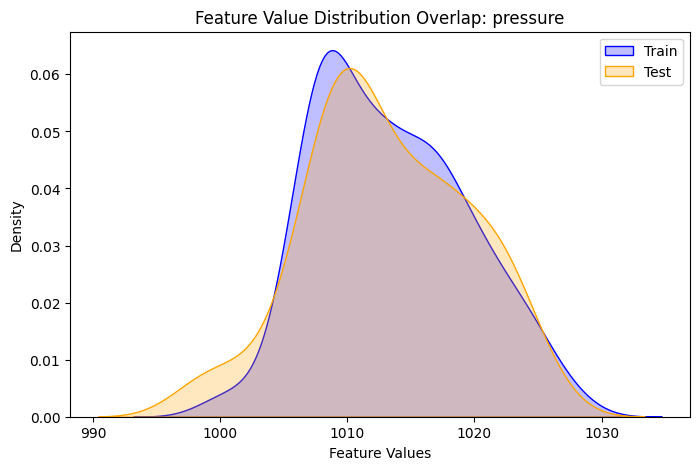

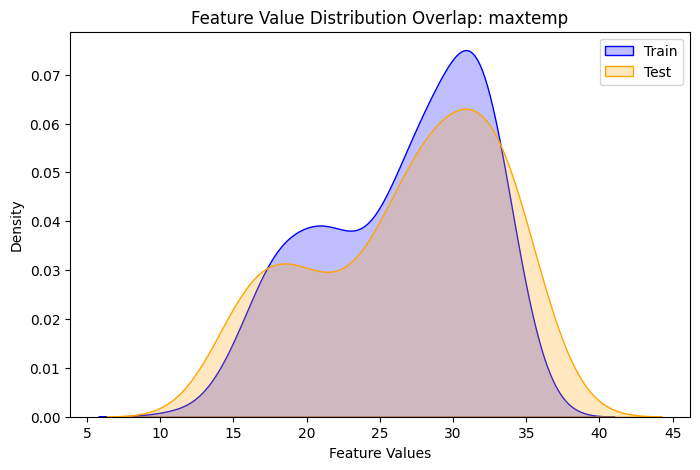

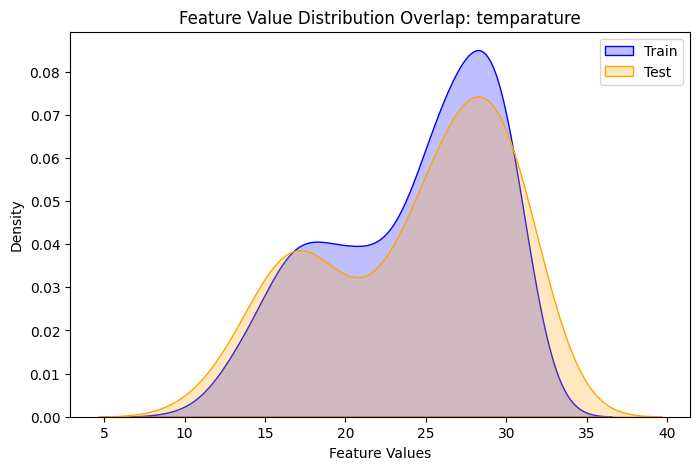

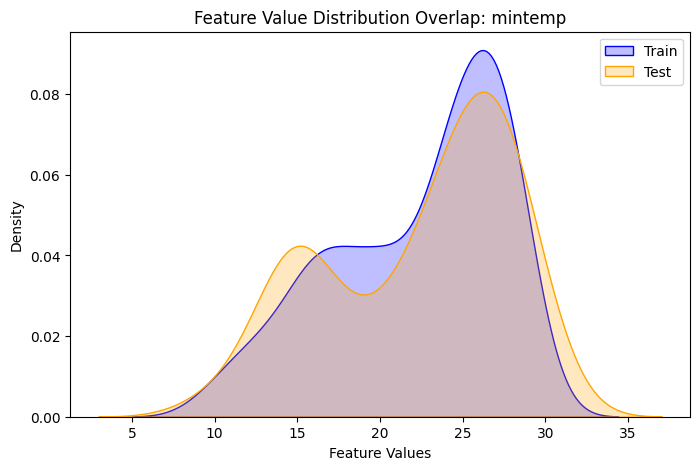

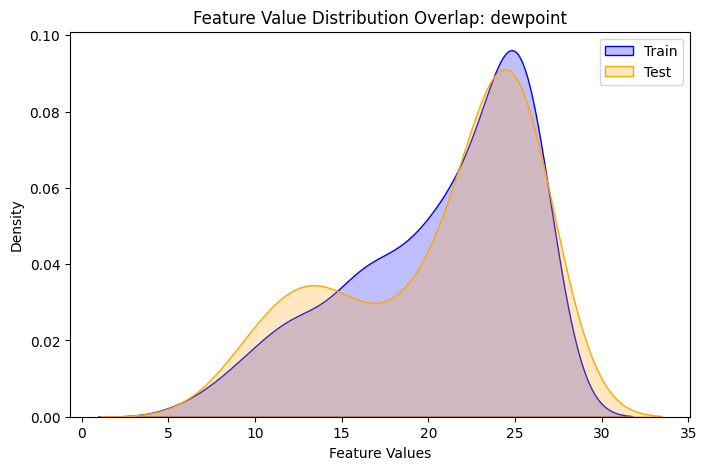

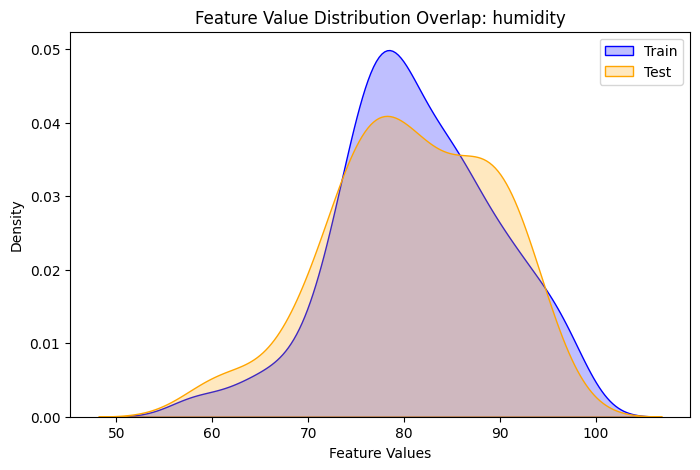

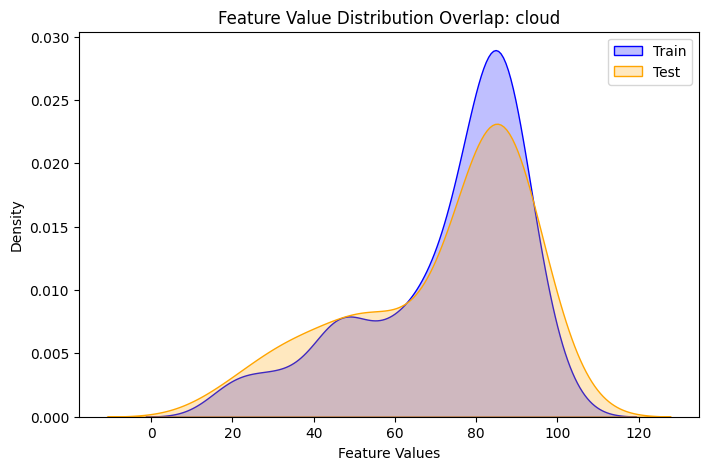

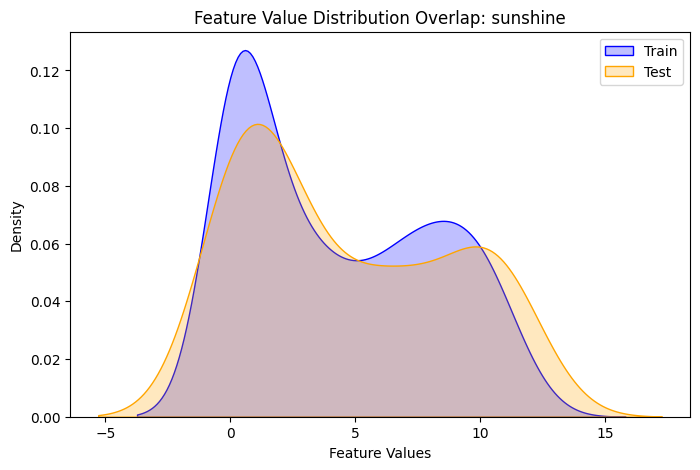

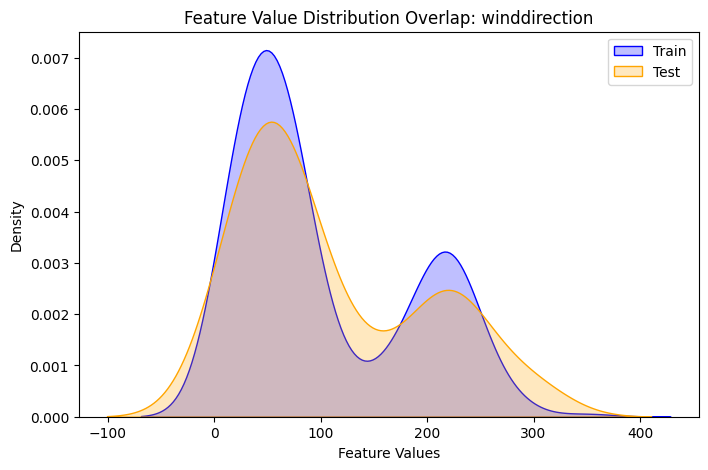

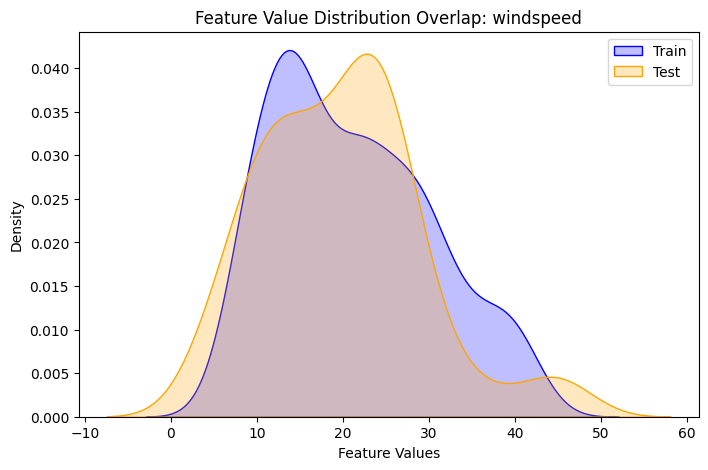

In [14]:
for feature_name in x_train.columns:
    
    x_train_feature = x_train[feature_name]
    x_test_feature = x_test[feature_name]
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.kdeplot(x_train_feature, label="Train", shade=True, color="blue")
    sns.kdeplot(x_test_feature, label="Test", shade=True, color="orange")
    plt.title(f"Feature Value Distribution Overlap: {feature_name}")
    plt.xlabel("Feature Values")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

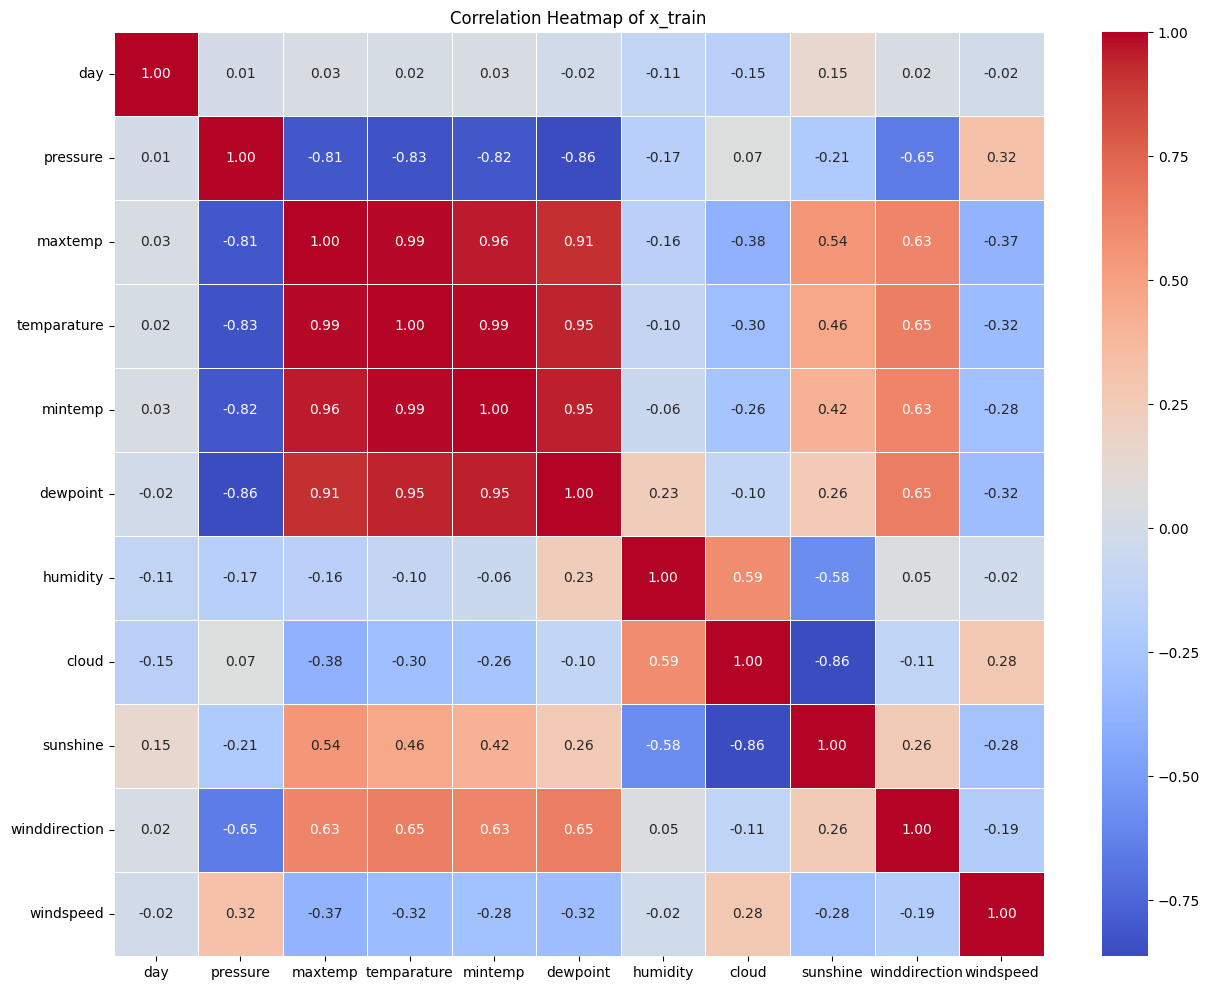

In [15]:
correlation_matrix = x_train.corr()  
plt.figure(figsize=(15, 12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap of x_train')
plt.show()

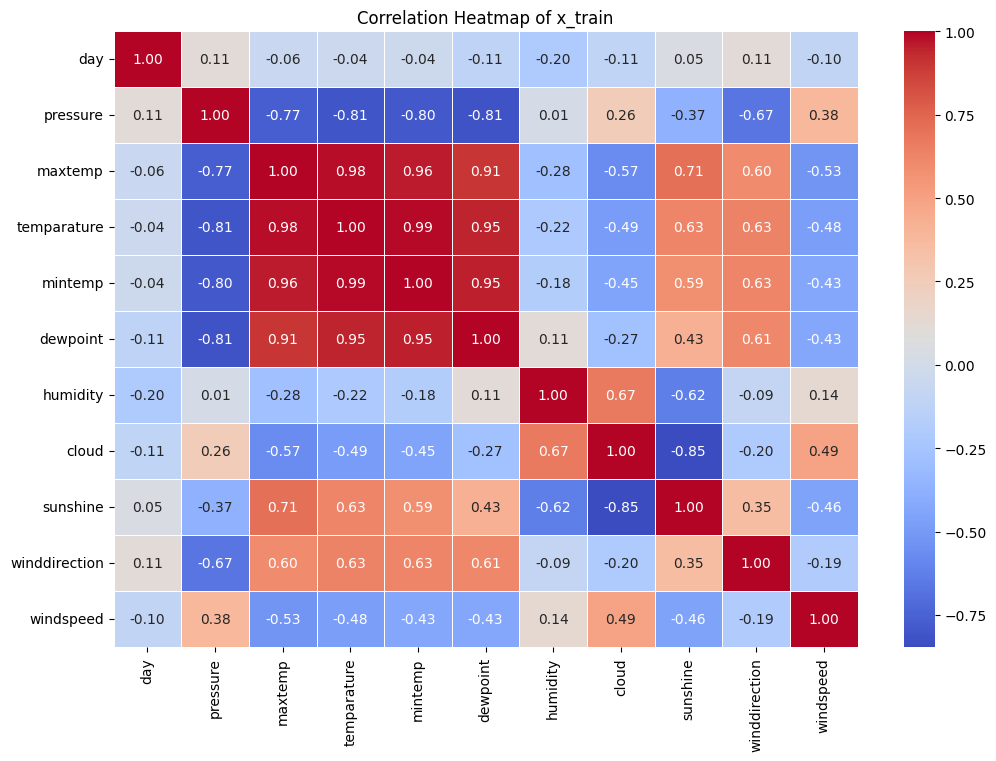

In [16]:
correlation_matrix = x_test.corr()  
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap of x_train')
plt.show()

In [17]:
x_train_with_const = add_constant(x_train)

vif_data = pd.DataFrame()
vif_data['Feature'] = x_train_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(x_train_with_const.values, i) 
                   for i in range(x_train_with_const.shape[1])]

print(vif_data)

          Feature            VIF
0           const  205983.665634
1             day       1.053981
2        pressure       5.112971
3         maxtemp      89.288098
4     temparature    1466.313919
5         mintemp      78.238059
6        dewpoint    1327.858918
7        humidity     137.491037
8           cloud       4.329119
9        sunshine       5.893221
10  winddirection       2.047295
11      windspeed       1.452573


In [18]:
x_test_with_const = add_constant(x_test)

vif_data = pd.DataFrame()
vif_data['Feature'] = x_test_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(x_test_with_const.values, i) 
                   for i in range(x_test_with_const.shape[1])]

print(vif_data)

          Feature            VIF
0           const  225378.352267
1             day       1.251981
2        pressure       5.530362
3         maxtemp     132.262957
4     temparature    2207.145330
5         mintemp     127.947784
6        dewpoint    1472.647046
7        humidity     157.717943
8           cloud       4.693821
9        sunshine       6.561838
10  winddirection       2.165944
11      windspeed       1.845078


In [19]:
x_train=x_train.drop(columns=['maxtemp','temparature','mintemp','dewpoint','humidity'],axis=1)

In [20]:
x_test=x_test.drop(columns=['maxtemp','temparature','mintemp','dewpoint','humidity'])

In [21]:
y_train.shape

(279,)

In [22]:
x_train.shape

(279, 6)

In [23]:
x_test

,day,pressure,cloud,sunshine,winddirection,windspeed
161,10,1005.7,80,4.5,220.0,14.6
334,30,1018.9,56,6.0,100.0,15.7
225,13,1007.9,84,0.1,230.0,22.9
155,4,1007.9,75,5.5,220.0,20.8
16,17,1011.5,79,1.6,20.0,23.4
...,...,...,...,...,...,...
133,13,1012.4,88,1.2,50.0,24.9
247,4,1013.1,60,8.7,80.0,9.8
172,21,1009.3,51,10.0,200.0,12.6
203,22,1010.3,29,11.4,240.0,14.5


In [55]:
signature = infer_signature(x_train, y_train)

rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    "n_estimators": [50, 100, 200,300],
    "max_depth": [None, 10, 20, 30,40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4,6]
}

scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)


grid_search = GridSearchCV(rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

with mlflow.start_run():

    grid_search.fit(x_train_sc, y_train)

    best_rf_model = grid_search.best_estimator_

    y_pred_test = best_rf_model.predict(x_test_sc)
    y_pred_train = best_rf_model.predict(x_train_sc)

    f1_test = f1_score(y_test, y_pred_test)
    
    mlflow.log_param("best n_estimators", grid_search.best_params_['n_estimators'])
    mlflow.log_param("best max_depth", grid_search.best_params_['max_depth'])
    mlflow.log_param("best min_samples_split", grid_search.best_params_['min_samples_split'])
    mlflow.log_param("best min_samples_leaf", grid_search.best_params_['min_samples_leaf'])

    
    mlflow.log_metric("f_test", f1_test)

    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    tracking_url = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url != 'file':
        mlflow.sklearn.log_model(best_rf_model, "model", registered_model_name="Best Random Forest Model")
    else:
        mlflow.sklearn.log_model(best_rf_model, "model", signature=signature)

    mlflow.sklearn.log_model(best_rf_model, "random_forest_model")

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f" F1 Test : {f1_test}")


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


2024/12/29 03:26:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Best Random Forest Model' already exists. Creating a new version of this model...
2024/12/29 03:26:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best Random Forest Model, version 15
Created version '15' of model 'Best Random Forest Model'.
2024/12/29 03:26:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
 F1 Test : 0.8775510204081632
🏃 View run salty-pig-396 at: http://127.0.0.1:5000/#/experiments/0/runs/55785b2e0a754027adf83fc2a943cd6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


100%|██████████| 279/279 [00:13<00:00, 20.11it/s]


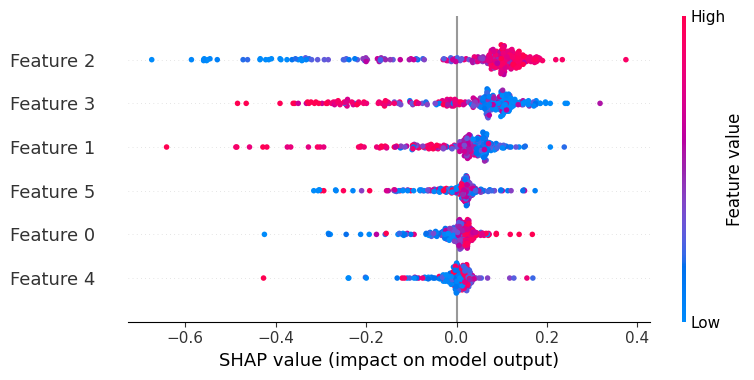

In [ ]:
# show importance of features for model
explainer = shap.KernelExplainer(best_rf_model.predict, x_train_sc[:100])  # Using a subset of the data
shap_values = explainer.shap_values(x_train_sc)
shap.summary_plot(shap_values, x_train_sc)


In [27]:
logged_model = 'runs:/e2f2d0ade94d44348f05c4196c43b17c/random_forest_model'

num_rows = 50
t_data = {
    'day': np.random.randint(1, 366, num_rows),  
    'pressure': np.random.uniform(1000, 1030, num_rows),  
    'cloud': np.random.randint(0, 101, num_rows),  
    'sunshine': np.random.uniform(0.0, 10.0, num_rows),  
    'winddirection': np.random.uniform(0.0, 360.0, num_rows),  
    'windspeed': np.random.uniform(0.0, 50.0, num_rows)  
}

loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model.predict(pd.DataFrame(t_data))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)